# 🧠 MediaSum Summary Quality Classifier (Random Forest)
This notebook loads summaries from MediaSum, extracts features (sentiment, keyword match, etc.),
trains a Random Forest to classify summary quality, and visualizes performance.

In [1]:
!pip install nltk yake scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 484.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 8.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile

def unzip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)

# Change these paths if your files are inside a subfolder
unzip("/content/drive/MyDrive/train_data.zip", "/content/train_data")
unzip("/content/drive/MyDrive/val_data.zip", "/content/val_data")
unzip("/content/drive/MyDrive/test_data.zip", "/content/test_data")


In [4]:
!ls /content/train_data
!ls /content/val_data
!ls /content/test_data


train_data.txt
val_data.txt
test_data.txt


In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import yake
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import nltk
nltk.download('vader_lexicon')

sentiment_analyzer = SentimentIntensityAnalyzer()
keyword_extractor = yake.KeywordExtractor(top=5, stopwords=None)

filler_words = ["um", "uh", "like", "you know", "I guess", "maybe", "sort of"]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
def load_jsonl(filepath, limit=None):
    data = []
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            data.append(json.loads(line))
            if limit and i + 1 == limit:
                break
    return data

In [7]:
# Load your data (adjust the paths as needed)
train_data = load_jsonl('/content/train_data/train_data.txt', limit=500)
val_data = load_jsonl('/content/val_data/val_data.txt', limit=200)
test_data = load_jsonl('/content/test_data/test_data.txt', limit=200)

In [8]:
def extract_features(entry):
    dialogue = " ".join(entry['utt'])
    summary = entry['summary']

    length = len(summary.split())
    sentiment = sentiment_analyzer.polarity_scores(summary)['compound']
    filler_count = sum(summary.lower().count(f) for f in filler_words)

    keywords = [kw for kw, _ in keyword_extractor.extract_keywords(dialogue)]
    matched = [kw for kw in keywords if kw.lower() in summary.lower()]
    keyword_coverage = len(matched) / len(keywords) if keywords else 0

    return [length, sentiment, filler_count, keyword_coverage]

In [21]:
def build_feature_matrix(data):
    def simulate_labels(X):
        y = []
        for length, sentiment, filler, coverage in X:
            score = 0
            score += (30 < length < 120) * 0.25
            score += (sentiment > 0.2) * 0.2
            score += (coverage > 0.4) * 0.4
            score += (filler < 3) * 0.15
            y.append(1 if score >= 0.6 else 0)
        return np.array(y)

    X = [extract_features(e) for e in data]
    y = simulate_labels(X)
    return np.array(X), y
X_train, y_train = build_feature_matrix(train_data)
X_val, y_val = build_feature_matrix(val_data)
X_test, y_test = build_feature_matrix(test_data)


In [10]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Predictions and classification report
val_preds = clf.predict(X_val)
test_preds = clf.predict(X_test)

print('📊 VAL SET METRICS')
print(classification_report(y_val, val_preds))
print('📊 TEST SET METRICS')
print(classification_report(y_test, test_preds))

📊 VAL SET METRICS
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       185
           1       0.32      0.67      0.43        15

    accuracy                           0.87       200
   macro avg       0.65      0.78      0.68       200
weighted avg       0.92      0.87      0.89       200

📊 TEST SET METRICS
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       110
           1       0.79      0.64      0.71        90

    accuracy                           0.77       200
   macro avg       0.77      0.75      0.76       200
weighted avg       0.77      0.77      0.76       200



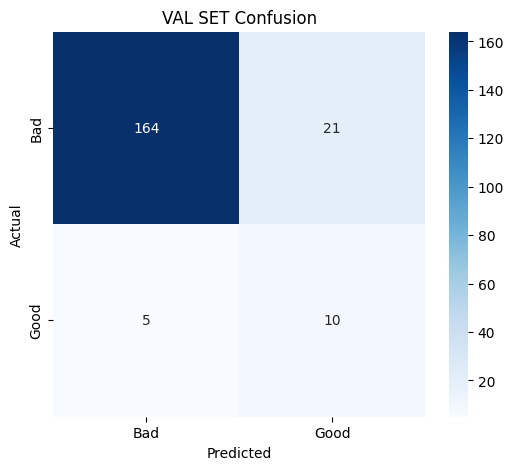

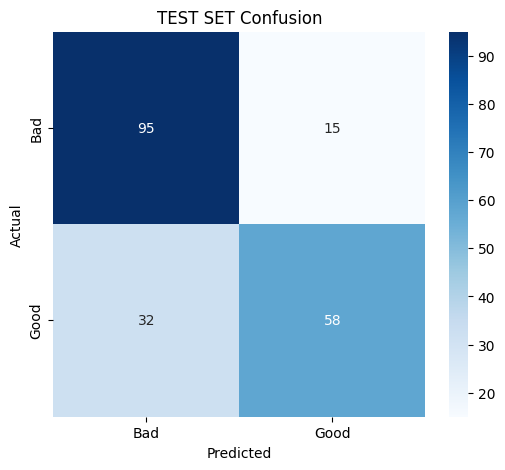

In [18]:
# Confusion matrix
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Bad", "Good"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion(y_val, val_preds, "VAL SET Confusion")
plot_confusion(y_test, test_preds, "TEST SET Confusion")

<ipython-input-19-37841f9f60d8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="pastel")


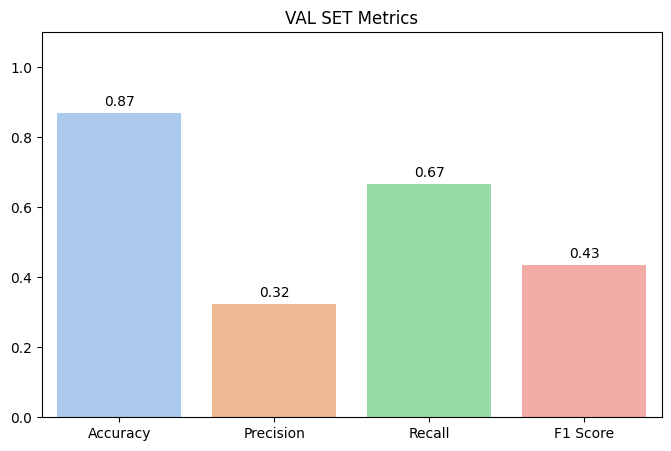

<ipython-input-19-37841f9f60d8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="pastel")


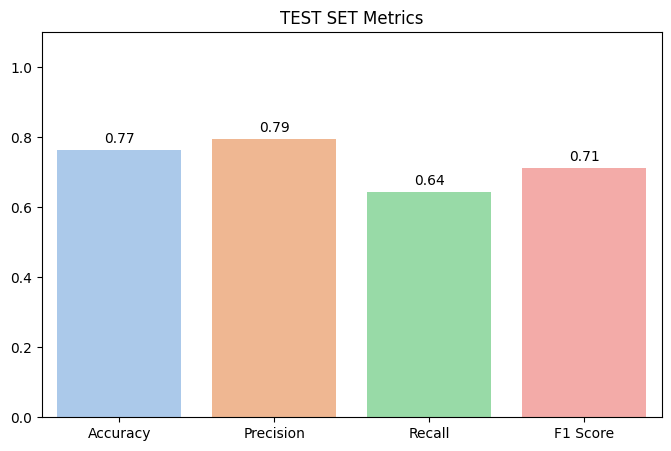

In [19]:
# Metric bar graph
def plot_metrics(y_true, y_pred, name=""):
    scores = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="pastel")
    plt.ylim(0, 1.1)
    plt.title(f"{name} Metrics")
    for i, val in enumerate(scores.values()):
        plt.text(i, val + 0.02, f"{val:.2f}", ha='center')
    plt.show()

plot_metrics(y_val, val_preds, "VAL SET")
plot_metrics(y_test, test_preds, "TEST SET")